In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from sklearn.metrics import classification_report
from torchvision.transforms.functional import rotate
from joblib import Parallel, delayed
import multiprocessing

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [5]:
IMAGE_SIZE = 33
BATCH_SIZE = 100

In [6]:
test_transform_1 = transforms.Compose([
                                       transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                       transforms.RandomRotation((90, 90)),
                                       transforms.RandomRotation((180, 180)),
                                       transforms.RandomRotation((270, 270)),
                                       transforms.ToTensor()
                                      ])

test_transform_2 = transforms.Compose([
                                       transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                       transforms.RandomRotation((0, 360)),
                                       transforms.ToTensor()
                                      ])


testset_1 = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/CENG501/data', 
                                       train=False,
                                       download=True, 
                                       transform=test_transform_1)

testloader_1 = torch.utils.data.DataLoader(testset_1, 
                                          batch_size=BATCH_SIZE,
                                         shuffle=False)

testset_2 = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/CENG501/data', 
                                       train=False,
                                       download=True, 
                                       transform=test_transform_2)

testloader_2 = torch.utils.data.DataLoader(testset_2, 
                                          batch_size=BATCH_SIZE,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


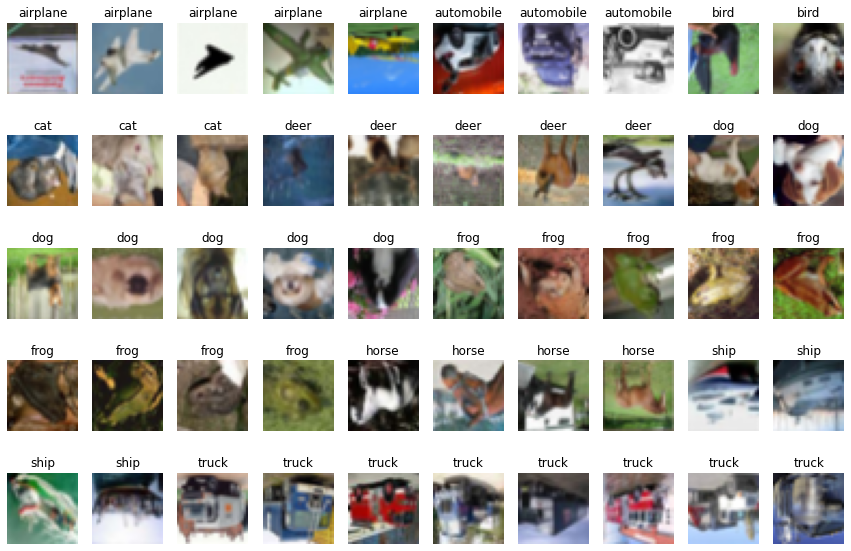

In [7]:
# visualization of CIFAR-10-rot test images
labels = 'airplane automobile bird cat deer dog frog horse ship truck'.split()
first_50_samples = sorted([testset_1[i] for i in range(50)], key=lambda x:x[1])

figure = plt.figure(figsize=(15,10))
for i in range(1,51):
    img = first_50_samples[i-1][0].permute(1,2,0)
    label = labels[first_50_samples[i-1][1]]
    figure.add_subplot(5,10,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

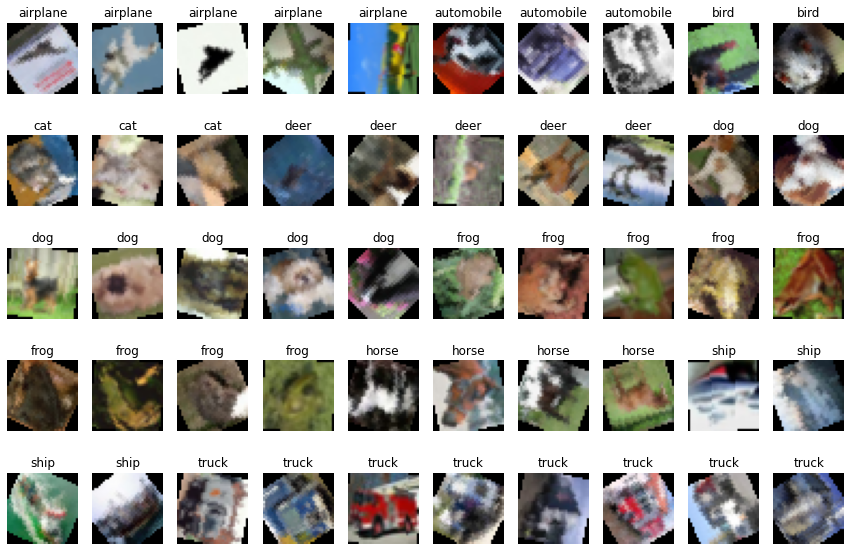

In [8]:
# visualizing CIFAR-10-rot+ test images
first_50_samples = sorted([testset_2[i] for i in range(50)], key=lambda x:x[1])

figure = plt.figure(figsize=(15,10))
for i in range(1,51):
    img = first_50_samples[i-1][0].permute(1,2,0)
    label = labels[first_50_samples[i-1][1]]
    figure.add_subplot(5,10,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

In [9]:
def print_results(model, test_loader):
  model.eval()
  y_pred_ls = []
  y_test_ls = []
  total = 0

  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_test_ls.extend(y_test.tolist())
      X_test = X_test.to(device)
      y_test = y_test.to(device)

      y_test_pred = model(X_test)

      predicted = torch.max(y_test_pred.data, 1)[1].tolist()
      y_pred_ls.extend(predicted)

  print(classification_report(y_pred_ls, y_test_ls))

## Without RRL

### LeNet 5

In [11]:
class LeNet5(nn.Module):
  def __init__(self, n_classes=10):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=(1, 1))
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=(1, 1))
    self.pooling = nn.AvgPool2d(kernel_size=(2, 2), stride=2)
    self.tanh = nn.Tanh()

    self.fc1 = nn.Linear(in_features=16*6*6, out_features=84)
    self.fc2 = nn.Linear(in_features=84, out_features=n_classes)

  def forward(self, x):
    x = self.tanh(self.conv1(x))
    x = self.pooling(x)

    x = self.tanh(self.conv2(x))
    x = self.pooling(x)

    x = torch.flatten(x, 1)
    x = self.tanh(self.fc1(x))

    x = self.fc2(x)
    return F.softmax(x, dim=1)

In [13]:
lenet = LeNet5().to(device)
lenet = torch.load('/content/drive/MyDrive/CENG501/models/lenet5_without_RRL.pth')

In [14]:
print("Results for CIFAR-10-rot test")
print_results(lenet, testloader_1)

print("\n Results for CIFAR-10-rot+ test")
print_results(lenet, testloader_2)

Results for CIFAR-10-rot test
              precision    recall  f1-score   support

           0       0.48      0.38      0.42      1258
           1       0.26      0.39      0.31       657
           2       0.32      0.27      0.29      1219
           3       0.24      0.16      0.19      1492
           4       0.27      0.23      0.25      1198
           5       0.26      0.22      0.24      1143
           6       0.46      0.37      0.41      1220
           7       0.04      0.07      0.06       592
           8       0.21      0.27      0.23       771
           9       0.07      0.16      0.10       450

    accuracy                           0.26     10000
   macro avg       0.26      0.25      0.25     10000
weighted avg       0.29      0.26      0.27     10000


 Results for CIFAR-10-rot+ test
              precision    recall  f1-score   support

           0       0.34      0.44      0.38       789
           1       0.19      0.45      0.27       420
           2   

### ResNet 18 - Without RRL

In [16]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1, padding=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=padding, bias=False)

In [17]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [18]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, downsample=None):
        super(ResNet, self).__init__()
        self.downsample = downsample
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2, padding=2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1, padding=1):
        if (stride != 1) or (self.in_channels != out_channels):
            self.downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride, padding=padding),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, self.downsample, padding=padding))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return F.softmax(x, dim=1)

In [19]:
resnet =  ResNet(ResidualBlock, [2, 2, 2]).to(device)
resnet = torch.load('/content/drive/MyDrive/CENG501/models/resnet18_without_RRL.pth')

In [20]:
print("Results for CIFAR-10-rot test")
print_results(resnet, testloader_1)

print("\n Results for CIFAR-10-rot+ test")
print_results(resnet, testloader_2)

Results for CIFAR-10-rot test
              precision    recall  f1-score   support

           0       0.67      0.37      0.48      1777
           1       0.12      0.56      0.20       224
           2       0.39      0.25      0.30      1561
           3       0.35      0.20      0.26      1738
           4       0.43      0.35      0.39      1215
           5       0.42      0.39      0.40      1098
           6       0.59      0.55      0.57      1083
           7       0.02      0.12      0.03       148
           8       0.11      0.33      0.17       340
           9       0.43      0.52      0.47       816

    accuracy                           0.35     10000
   macro avg       0.35      0.36      0.33     10000
weighted avg       0.44      0.35      0.38     10000


 Results for CIFAR-10-rot+ test
              precision    recall  f1-score   support

           0       0.29      0.44      0.35       656
           1       0.06      0.67      0.12        95
           2   

## LeNet5 - With RRL

In [22]:
def rotate_mx(mx, degree):
	return rotate(mx.unsqueeze(0), degree).squeeze(0)

In [24]:
# calculating local binary pattern value
def LPB(mx):
  mid = mx.shape[0] // 2
  threshold = mx[mid, mid]

  bin_mx = (mx >= threshold)
  power_mx = torch.Tensor([
                       [1, 2, 4],
                       [8, 0, 16],
                       [32, 64, 128]
  ]).to(device)

  return (bin_mx * power_mx).sum()

In [25]:
# finding rotation matrix leading to minimum LPB value
def min_lpb(mx, mx2=None):
  num_of_surr_elements = mx.shape[0] ** 2 - 1
  rot_deg = 360 // num_of_surr_elements

  min_mx = mx.clone()
  lpb = LPB(mx)
  for degree in range(rot_deg, 360, rot_deg):
    mx = rotate_mx(mx, degree)
    cur_lpb = LPB(mx)

    if cur_lpb < lpb:
      lpb = cur_lpb
      min_mx = mx.clone()
     
  return min_mx

In [26]:
class RRL(nn.Module):
  def __init__(self, kernel_size=3, padding=(0, 0)):
    super(RRL, self).__init__()
    self.FH = self.FW = self.stride = kernel_size
    self.padding = padding

  def forward(self, x):
    # x -> (batch_size, channels, height, width)
    # OH, OW - feature map height and width
    # FH, FW - kernel height and width

    batch_size, ch, H, W = x.shape
    OH = H // self.FH
    OW = W // self.FW

    # pad the input
    x = F.pad(x, pad=self.padding)
    
    # create sliding windows
    x = x.unfold(2, self.FH, self.stride).unfold(3, self.FW, self.stride) # x -> (batch_size, channels, OH, OW, FH, FW)
    x = x.contiguous().view(batch_size, ch, -1, self.FH, self.FW) # x -> (batch_size, channels, OH*OW, FH, FW)
    x = x.permute(0, 2, 1, 3, 4) # x -> (batch_size, OH*OW, channels, FH, FW)

    
    # calculate minimum LPB state for all the windows 
    #x = vmap(min_lpb, in_dims=(-2, -1), out_dims=(-2, -1))(x) # x -> (batch_size, OH*OW, channels, FH, FW)

    num_cores = multiprocessing.cpu_count()
    x = Parallel(n_jobs=num_cores, backend="threading")(delayed(min_lpb)(x[b, o, c, :, :]) for b in range(batch_size) for o in range(OH*OW) for c in range(ch))
    x = torch.stack(x).view(batch_size, OH*OW, ch, self.FH, self.FW)

    # reshape matrix into original format
    x = x.permute(0, 2, 1, 3, 4) # x -> (batch_size, channels, OH*OW, FH, FW)
    x = x.view(batch_size, ch, OH, OW, self.FH, self.FW) # x -> (batch_size, channels, OH, OW, FH, FW)
    x = x.permute(0, 1, 2, 4, 3, 5) # x -> (batch_size, channels, OH, FH, OW, FW)
    x = x.contiguous().view(batch_size, ch, H, W) # x -> (batch_size, channels, OH*FH, OW*FW)
 
    return x

In [27]:
class LeNet5_with_RRL(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=(1, 1))
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=(1, 1))
    self.pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
    self.RRL = RRL()
    self.tanh = nn.Tanh()

    self.fc1 = nn.Linear(in_features=16*6*6, out_features=84)
    self.fc2 = nn.Linear(in_features=84, out_features=n_classes)

  def forward(self, x):
    x = self.RRL(x)
    x = self.tanh(self.conv1(x))
    x = self.pooling(x)

    x = self.RRL(x)
    x = self.tanh(self.conv2(x))
    x = self.pooling(x)

    x = self.RRL(x)

    x = torch.flatten(x, 1)
    x = self.tanh(self.fc1(x))

    x = self.fc2(x)
    return F.softmax(x, dim=1)

In [28]:
lenet_rrl =  LeNet5_with_RRL(10)
lenet_rrl = torch.load('/content/drive/MyDrive/CENG501/models/lenet5_with_rrl.pth')

In [ ]:
print("Results for CIFAR-10-rot test")
print_results(lenet_rrl, testloader_1)

print("\n Results for CIFAR-10-rot+ test")
print_results(lenet_rrl, testloader_2)

Results for CIFAR-10-rot test


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.76      0.19      0.30      4106
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.64      0.11      0.18      5892
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         0

    accuracy                           0.14     10000
   macro avg       0.14      0.03      0.05     10000
weighted avg       0.69      0.14      0.23     10000


 Results for CIFAR-10-rot+ test


## ResNet18 - With RRL

In [ ]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1, padding=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=padding, bias=False)

In [ ]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, downsample=None):
        super(ResNet, self).__init__()
        self.downsample = downsample
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2, padding=2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        self.RRL = RRL()

    def make_layer(self, block, out_channels, blocks, stride=1, padding=1):
        if (stride != 1) or (self.in_channels != out_channels):
            self.downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride, padding=padding),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, self.downsample, padding=padding))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.RRL(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        x = self.RRL(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.RRL(x)

        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return F.softmax(x, dim=1)

In [ ]:
resnet18_rrl =  ResNet(ResidualBlock, [2, 2, 2]).to(device)
resnet18_rrl = torch.load('/content/drive/MyDrive/CENG501/models/resnet18_with_rrl.pth')

In [ ]:
print("Results for CIFAR-10-rot test")
print_results(resnet18_rrl, testloader_1)

print("\n Results for CIFAR-10-rot+ test")
print_results(resnet18_rrl, testloader_2)